In [4]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score

# Load and process MNIST data for image classification

#### Load the MNIST dataset. 

The MNIST dataset is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. We use pixel values as features to build a neural network to predict the `digit` of an image. So there are 10 labels of this dataset, including "0", "1", "2", "3", "4", "5", "6", "7", "8", and "9".

Loading MNIST data of 70,000 images may take some time.

In [18]:
#Convert the dataset into Tensor used by PyTorch
transform=transforms.Compose([
         transforms.ToTensor(),
        ])

#Download the MINST data directly from PyTorch
#The downloaded datasets are stored in the same folder with this jupyter notebook file
#For train dataset, use "train=True"
#For test dataset, use "train=False"
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

#Load the datasets into DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

class_names = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']

The size of each image in MNIST data is 28x28. Different from multi-layer perceptron, each image is fed as 28x28 matrix to convolutional neural network directly

In [22]:
#One batach has 64 images
dataiter = iter(train_dataloader)
samples = next(dataiter)
print(samples[0].shape)
print(samples[1].shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


#### Plot some MNIST examples

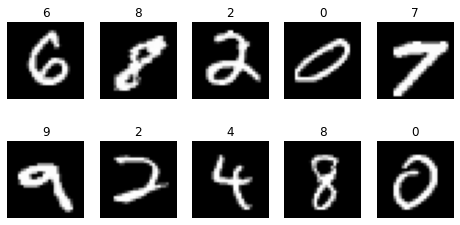

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Plot the data
def plot_digits(instances, labels, images_per_row=5):
    for i in range(len(instances)):
        idx = i // images_per_row
        idy = i % images_per_row 
        ax[idx, idy].imshow(instances[i].squeeze(), cmap="gray")
        ax[idx, idy].set_title(class_names[labels[i]])
        ax[idx, idy].axis("off")

fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = samples[0][:10]
example_labels = samples[1][:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

# Use PyTorch to build a convolutional neural network for image classification

#### Define a class to construct all the layers in the convolutional neural network

In [23]:
np.random.seed(42)
torch.manual_seed(42)

class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) #1 input channel to 10 channels
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)#10 channels to 20 channels
        self.fc1 = nn.Linear(320, 50) 
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))   #Use ReLU as activation function
        x = F.max_pool2d(x, 2)      #Apply max_pooling on the output of the convolution layer
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Set up some hyperparameters: use cross entropy loss, adam optimizer, and epochs

In [24]:
epochs = 10
learning_rate = 0.01
weight_decay = 5e-4
lossfunction = nn.CrossEntropyLoss()

model = ClassificationNet()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

print(model)

ClassificationNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


#### Train the model

In [29]:
#Define the training function
def train(epoch):
    model.train()
    
    running_loss = 0.0
    train_total, train_correct = 0.0, 0.0    
    y_train, y_pred = [], []
    
    for i, (features, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()

        outputs = model(features)

        loss = lossfunction(outputs, labels.long())
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        _, train_predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels.long()).sum().item()
        y_train += labels.tolist()
        y_pred += train_predicted.tolist()
        
        if i % 200 == 0:
            print('Epoch: {} [{}/{} ({:.0f}%)]\tloss: {:.6f}'.format(
                epoch, i * len(features), len(train_dataloader.dataset),
                100. * i / len(train_dataloader), loss.item()))

    macro_f1 = f1_score(y_train, y_pred, average='macro')
    print("epoch (%d): Train accuracy: %.4f, f1_score: %.4f, loss: %.3f" % (epoch, train_correct/train_total, macro_f1, running_loss/train_total))
    
    
#Train the model
for epoch in range(1, epochs + 1):
    train(epoch)

Epoch: 1 [0/60000 (0%)]	loss: 0.026228
Epoch: 1 [12800/60000 (21%)]	loss: 0.026062
Epoch: 1 [25600/60000 (43%)]	loss: 0.048392
Epoch: 1 [38400/60000 (64%)]	loss: 0.020882
Epoch: 1 [51200/60000 (85%)]	loss: 0.047322
epoch (1): Train accuracy: 0.9789, f1_score: 0.9788, loss: 0.001
Epoch: 2 [0/60000 (0%)]	loss: 0.014575
Epoch: 2 [12800/60000 (21%)]	loss: 0.058016
Epoch: 2 [25600/60000 (43%)]	loss: 0.007251
Epoch: 2 [38400/60000 (64%)]	loss: 0.077583
Epoch: 2 [51200/60000 (85%)]	loss: 0.040504
epoch (2): Train accuracy: 0.9793, f1_score: 0.9792, loss: 0.001
Epoch: 3 [0/60000 (0%)]	loss: 0.043244
Epoch: 3 [12800/60000 (21%)]	loss: 0.080794
Epoch: 3 [25600/60000 (43%)]	loss: 0.142742
Epoch: 3 [38400/60000 (64%)]	loss: 0.068778
Epoch: 3 [51200/60000 (85%)]	loss: 0.039966
epoch (3): Train accuracy: 0.9798, f1_score: 0.9796, loss: 0.001
Epoch: 4 [0/60000 (0%)]	loss: 0.032839
Epoch: 4 [12800/60000 (21%)]	loss: 0.048726
Epoch: 4 [25600/60000 (43%)]	loss: 0.020722
Epoch: 4 [38400/60000 (64%)]	loss

# Evaluate the trained convolutional neural network

In [31]:
#Define the test function
def test():
    model.eval()
    
    test_correct, test_total = 0.0, 0.0
    y_test, y_pred = [], []
    
    with torch.no_grad():
        for features, labels in test_dataloader:
            outputs = model(features)
            
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels.long()).sum().item()
            y_test += labels.tolist()
            y_pred += predicted.tolist()

    macro_f1 = f1_score(y_test, y_pred, average='macro')
    print('Test accuracy: %.4f, macro f1_score: %.4f' % (test_correct / test_total, macro_f1))
    
    return y_test, y_pred

#Test the model
y_test, y_pred = test()

Test accuracy: 0.9808, macro f1_score: 0.9807


#### Output the confusion matrix

In [32]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[ 969    0    1    0    0    1    6    2    1    0]
 [   0 1118    2    0    0    2    1    7    5    0]
 [   1    0 1016    1    0    1    0   12    1    0]
 [   0    0    0  996    0    6    0    8    0    0]
 [   0    0    2    0  955    0    0    5    4   16]
 [   0    0    0    4    0  886    2    0    0    0]
 [   5    2    0    0    1    3  947    0    0    0]
 [   0    0    4    1    0    2    0 1021    0    0]
 [   1    0    4    2    1    8    7    3  946    2]
 [   1    2    2    2    4   16    0   22    6  954]]


#### Calculate accuracy, macro F1-score, and micro F1-score

In [33]:
from sklearn.metrics import accuracy_score, f1_score

acc = accuracy_score(y_test, y_pred)
macrof1 = f1_score(y_test, y_pred, average='macro')
microf1 = f1_score(y_test, y_pred, average='micro')
print('Accuracy: {:.2f}'.format(acc))
print('Macro F1-score: {:.2f}'.format(macrof1))
print('Micro F1-score: {:.2f}'.format(microf1))

Accuracy: 0.98
Macro F1-score: 0.98
Micro F1-score: 0.98
